In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sklearn
import lzma
import nltk

from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
#Any global parameters to adjust will go here
plt.rcParams.update({'font.size': 20})
%pprint

Pretty printing has been turned OFF


<i>Replacement Notebook</i>
<h1>Phase 3</h1>
<p>We're really getting down to the wire here. The main focus will be on the machine learning. Establishing the baseline perccentage on the selected subreddits, and then trying to improve that score as much as possible.</p>

<a id="toc"></a>
<h2>Table of Contents</h2>
<ol>
    <li><a href="#loading">Loading the data and Setting Target Subreddits</a></li>
    <li><a href="#breakdown">Breakdown of Subreddits</a></li>
    <li><a href="#baseline">Baseline Machine Learning</a></li>
    <li><a href="#optimal">Finding the Optimal Parameters</a></li>
    <li><a href="#features">Trying additonal features</a></li>
    <li><a href="#publishing">Publishing Above50t Frame</a></li>
</ol>

<a id="loading"></a>
<h2>Loading the data and Setting the Target Subreddits [<a href="#toc">TOC</a>]</h2>
<p>So first off, we have to load the data. And then we have to set our target subreddits.</p>

In [3]:
redditframe=pd.read_pickle("../data/TokenizedRedditframe.pkl")

In [4]:
above50 = redditframe[redditframe.score >= 50]

In [5]:
targetsubreddits=["relationships", "aww", "nfl", "PrequelMemes", "gaming", "mildlyinteresting", "politics", "Showerthoughts","worldnews","gifs", "StarWars", "funny"]

In [6]:
above50t = above50[above50.subreddit.isin(targetsubreddits)]
above50t.to_pickle("../data/MLdata.pkl")

<p>The data has been loaded and the target subreddits has been set. I pickle them here so that I can scp them onto the CRC server. Let's do this.</p>

<a id="breakdown"></a>
<h2>Breakdown of Subreddits [<a href="#toc">TOC</a>]</h2>
<p>Since this wasn't covered in the previous phase, I'll have to breakdown the subreddits real quick.</p>

In [7]:
above50t.subreddit.value_counts()

politics             1786
nfl                  1019
worldnews             995
StarWars              851
gaming                691
relationships         631
funny                 580
Showerthoughts        479
aww                   362
gifs                  324
mildlyinteresting     206
PrequelMemes          130
Name: subreddit, dtype: int64

<p>Hmm, Politics is more disporportionate than I thought, but it's not as bad as AskReddit. I'll roll with it for now, but I might have to change it out for something else if needed.</p>

In [8]:
above50t.groupby("subreddit").score.mean()

subreddit
PrequelMemes         150.469231
Showerthoughts       400.661795
StarWars             149.481786
aww                  376.994475
funny                450.589655
gaming               419.299566
gifs                 757.317901
mildlyinteresting    492.194175
nfl                  175.197252
politics             228.754759
relationships        154.890650
worldnews            399.067337
Name: score, dtype: float64

<p>Gifs seems to have an unsually high average despite not being the smallest. Otherwise, the average seems to correlate with the size, but not alone since PrequelMemes is the smallest and has the smallest average.</p>

In [9]:
len(above50t)

8054

In [10]:
sum(above50t["numtokens"])

336306

<p>The amount of data we're working with has greatly shrunken compared to our original corpus. 8054 comments, 336306 words.</p>

<a id="baseline"></a>
<h2>Baseline Machine Learning [<a href="#toc">TOC</a>]</h2>
<p>For this section, we'll run machine learning on some basic parameters, to gauge of how progress we have to do. We'll run one run of each, no cross-validation until we get to the grid search. To make things interesting, we'll use multiple machine learning algorithms. First off, we must determine the percentage of each subreddit so that we can see who is the largest, and what value the accuracy score must clear...</p>

In [11]:
#A quick function to repeatedly plot the confusionmatrices
def plotConfusionMatrix(cm):
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', square=True, cmap="icefire")
    plt.xlabel('Predicted')
    plt.ylabel('Actual Value')
    plt.show()

In [12]:
for i in targetsubreddits:
    print(len(above50t[above50t.subreddit==i])/len(above50t), i)

0.07834616339706978 relationships
0.044946610379935435 aww
0.12652098336230444 nfl
0.01614104792649615 PrequelMemes
0.08579587782468338 gaming
0.025577352868140054 mildlyinteresting
0.22175316612863175 politics
0.059473553513781974 Showerthoughts
0.123541097591259 worldnews
0.04022845790911348 gifs
0.10566178296498634 StarWars
0.07201390613359822 funny


<p>Politics makes up the largest portion at 22%. Therefore, we must get above 22% for our classifier to even be remotely classified as successful.</p>
<p>Moving on, we'll split the data for our singular basic runs.</p>

In [13]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["body"], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [14]:
vectorizer = TfidfVectorizer(min_df=2)
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=2)), ('MNB', MultinomialNB())])

In [15]:
model.fit(trainingdata, y_train)

Pipeline(memory=None,
     steps=[('Tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...rue,
        vocabulary=None)), ('MNB', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [16]:
y_pred = model.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)

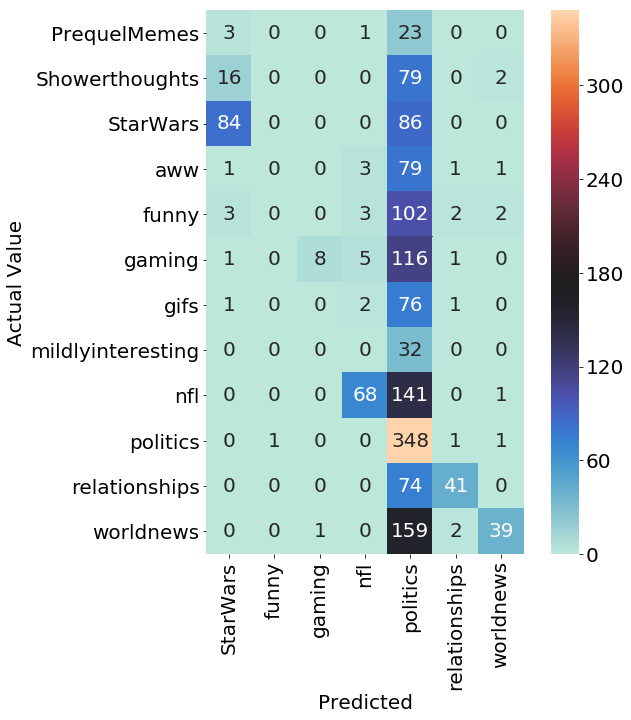

In [17]:
plotConfusionMatrix(cm)

In [18]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.3649906890130354

<p>14% increase from the baseline of 22%! Getting this without trying gives me hope of room for great improvement.</p>

In [19]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=2)), ('SVC', SVC(kernel='linear', C=1E5))])
svd = SVC(kernel='linear', C=1E5)
model.fit(trainingdata, y_train)

Pipeline(memory=None,
     steps=[('Tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [20]:
y_pred = model.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)

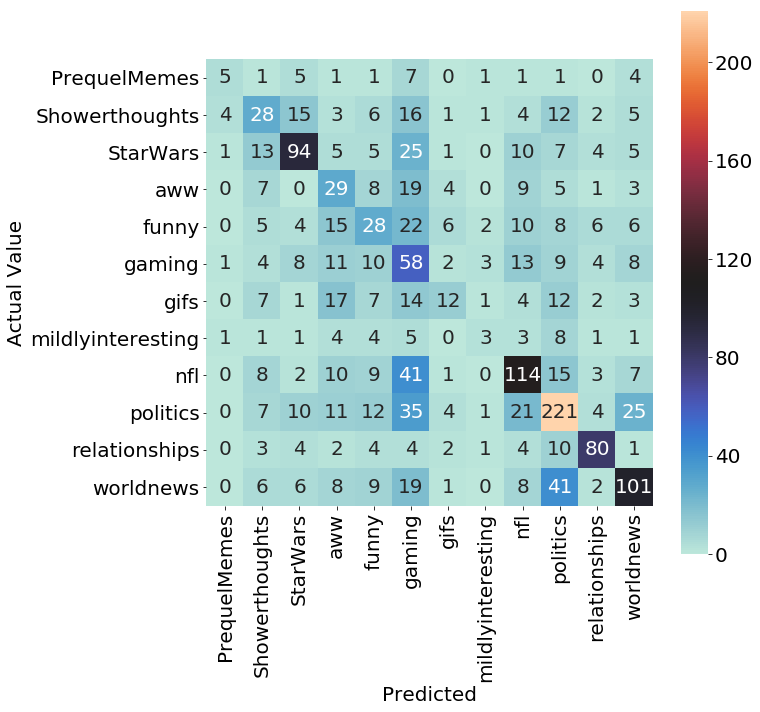

In [21]:
plotConfusionMatrix(cm)

In [22]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.4798261949099938

<p>36% and 48% for each algorithm separately. Not off to a great start, but at the same time we have lots of room for improvement.</p>

<a id="optimal"></a>
<h2>Finding the Optimal Parameters [<a href="#toc">TOC</a>]</h2>
<p>I've ported this off too the CRC to take advantage of their resources to run a lot of parameters. Let's see what the most optimal parameters are for each algorithm. Features tested :</p>

<b>TfidfVectorizer</b>
<ul>
    <li>max_features:[None, 1500, 3000, 5000, 7500]</li>
    <li>min_df:[1,2,3,4,5]</li>
    <li>norm:['l1', 'l2', None]</li>
    <li>ngram_range:[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]</li>
</ul>

<b>MultinomialNB</b>
<ul>
    <li>alpha:[0.01, 0.25, 0.5, 0.75, 1.00]</li>
</ul>

<b>SVC</b>
<ul>
    <li>kernel:["linear", "poly", "rbf", "sigmoid"]</li>
    <li>gamma:['auto','scale']</li>
</ul>


<p><b>Update:</b> The support vector algorithm did not finish within the time limit of 10 hours and the progress report is due in less than 24 hours. I will have to run with the TDidf features found in the grid search for Multinomial on this front. I will perform a local grid search to see which kernel is the best, though I suspect it might remain linear since I'm not playing around with the features that go with the other kernels (to save time). You can find my CRC results <a href="../CRC/multibest.txt">here</a>.</p>
<p>You might be wondering why I'm using the max_features cap even though the grid search returned None as the best? I discuseed some things with Na Rae in office hours and the topic came up. It's usually practical to have some cap on models regardless.</p>

In [23]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1, max_features=15000)), ('SVC', SVC(C=1E5))])
param_grid = {
    "SVC__kernel":["linear", "poly", "rbf", "sigmoid"],
    "SVC__gamma":["auto","scale"]
}
grid = GridSearchCV(model, param_grid, n_jobs=2, cv=5)
grid.fit(above50t["body"], above50t["subreddit"])
grid.best_params_

{'SVC__gamma': 'auto', 'SVC__kernel': 'sigmoid'}

<p>The most optimal kernel, actually turned out to be sigmoid. That's somewhat surprising, but I'll go with it for now. Let's run 5-fold cross validation.</p>

In [52]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1, max_features=15000)), ('SVC', SVC(kernel="sigmoid",gamma="auto",C=1E5))])
scores = cross_validate(model, above50t["body"], above50t["subreddit"], cv=5)

In [53]:
print(scores)
print("Test average :",scores["test_score"].mean())

{'fit_time': array([80.94818687, 80.40845537, 78.95685744, 84.67710567, 89.56596851]), 'score_time': array([ 9.38618588,  9.41514993, 13.32402611, 10.87858582, 11.35426736]), 'test_score': array([0.47710396, 0.48541279, 0.47639752, 0.49875776, 0.45612943]), 'train_score': array([0.99332091, 0.99301568, 0.99394786, 0.99394786, 0.99364045])}
Test average : 0.4787602921430705


<p>Huh, that's weird, we got a much lower accuracy score than before... I whole heartedly believe this partially due to cross-validation versus one singular run. Out of curiosity, let's test our new model on the singular run, same random seed. We'll skip the confusion matrix since it's the accuracy we're focusing on...</p>

In [26]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["body"], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [27]:
#I forget if you have to reset the model after you fit it on data, so this is a precaution
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1, max_features=15000)), ('SVC', SVC(kernel="sigmoid",gamma="auto",C=1E5))])
model.fit(trainingdata, y_train)
y_pred = model.predict(testingdata)

sklearn.metrics.accuracy_score(y_test, y_pred)

0.5226567349472377

<p>Aha! So our singular run is not a reliable source to compare to. But, at least we have some idea of knowing that we improved. Also being 25% above the minimum via cross validation is still a good sign. Let's give our Multinomial Naivve Baye's a spin...</p>
<h4>MultinomialNB</h4>

In [28]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1, max_features=15000)), ('MNB', MultinomialNB(alpha=0.01))])
scores = cross_validate(model, above50t["body"], above50t["subreddit"], cv=5)
print("Test average :",scores["test_score"].mean())

Test average : 0.5420922965374333


<p>Hmmm, Multinomial Naive Bayes is actually coming out ahead of Support Vectors on this one! Let's compare the single run performance.</p>

In [29]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1, max_features=15000)), ('MNB', MultinomialNB(alpha=0.01))])
model.fit(trainingdata, y_train)
y_pred = model.predict(testingdata)

sklearn.metrics.accuracy_score(y_test, y_pred)

0.5828677839851024

<p>I see, Either I did not try enough SVC features, or Multinomial is actually better suited for the task when finely tuned. Nonetheless, we have observed improvements over the models! Now we can move onto trying additional features.</p>

<a id="features"></a>
<h2>Trying Additional Features [<a href="#toc">TOC</a>]</h2>
<p>Now that we have somewhat optimized our models, we can move onto trying additional features.</p>
<h4>Some Stabs in the dark</h4>
This first section are some things I tried before learning how to combine vectorized textual features with non-textual features. I won't go over this small section that much as a result.</p>

In [30]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t[["score","author_cakeday","controversiality"]], above50t["subreddit"], test_size = 1/5, random_state = 0)

In [31]:
testthis = MultinomialNB(alpha=0.01)

In [32]:
testthis.fit(trainingdata,y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

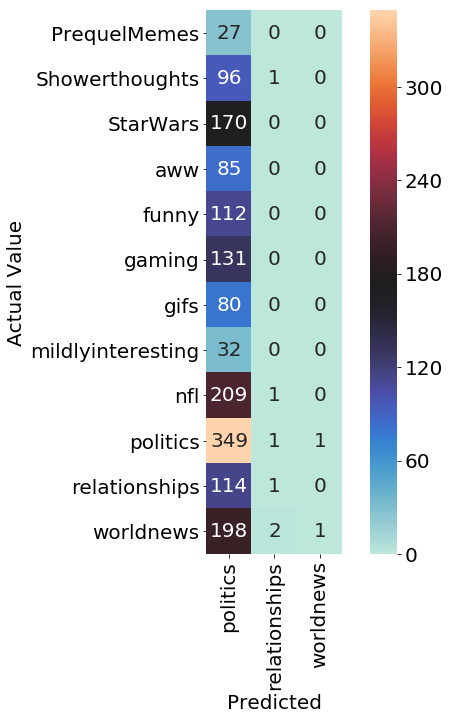

In [33]:
y_pred = testthis.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)
plotConfusionMatrix(cm)

In [34]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.21787709497206703

<p>Wow, we even managed to go below 22% ever so slightly. Yup, this won't work. I believe using the parent ID is cheating since that points to one specific post, and each post can only be on one subreddit. Let's see what happens when I use it as the sole feature.</p>

In [35]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t["parent_id"], above50t["subreddit"], test_size = 1/5)

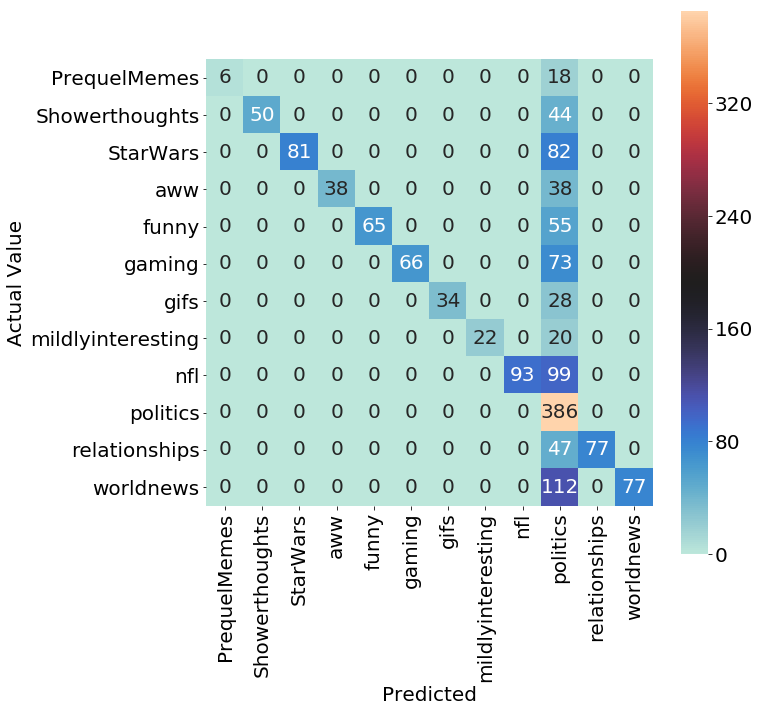

In [36]:
model = Pipeline(steps=[('Tfidf', TfidfVectorizer(min_df=1)), ('SVC', SVC(kernel='sigmoid', gamma="auto", C=1E5))])
model.fit(trainingdata,y_train)
y_pred = model.predict(testingdata)
cm = pd.crosstab(y_test, y_pred)
plotConfusionMatrix(cm)

In [37]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.6176288019863438

<p>Yup, it correctly identifies posts with parent ID's it has seen, and then defaults to the biggest data sample (politics) if it encounters a parent ID it has never seen before. Therefore, using the parent ID is not a good idea as it has a 1 to 1 correlation with subreddits and thus negates the point of the exercise.</p>
<h4>Some slightly better stabs in the dark.</h4>
<p>Now we combine textual features with non-textual features. Let's try the score again, but fit it with the text. We won't have the luxury of pipeline (unless there's a way to accomodate this). Also, since I'm just observing, I'll do singular runs for now, but then do cross-validation on the best candidates.</p>

In [38]:
vectorizer = TfidfVectorizer(min_df=1, max_features=15000)

In [39]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t[["body", "score","gilded"]], above50t["subreddit"], test_size = 1/5)

In [40]:
numberfeaturetr = coo_matrix(trainingdata[["score","gilded"]])
numberfeaturete = coo_matrix(testingdata[["score","gilded"]])
traintf = vectorizer.fit_transform(trainingdata["body"])
testtf = vectorizer.transform(testingdata["body"])

trainmatrix = coo_matrix(traintf)

print(traintf.shape)
print(numberfeaturetr.shape)

trcombostack = hstack([traintf, numberfeaturetr])
tecombostack = hstack([testtf, numberfeaturete])

(6443, 15000)
(6443, 2)


0.5356921166977033


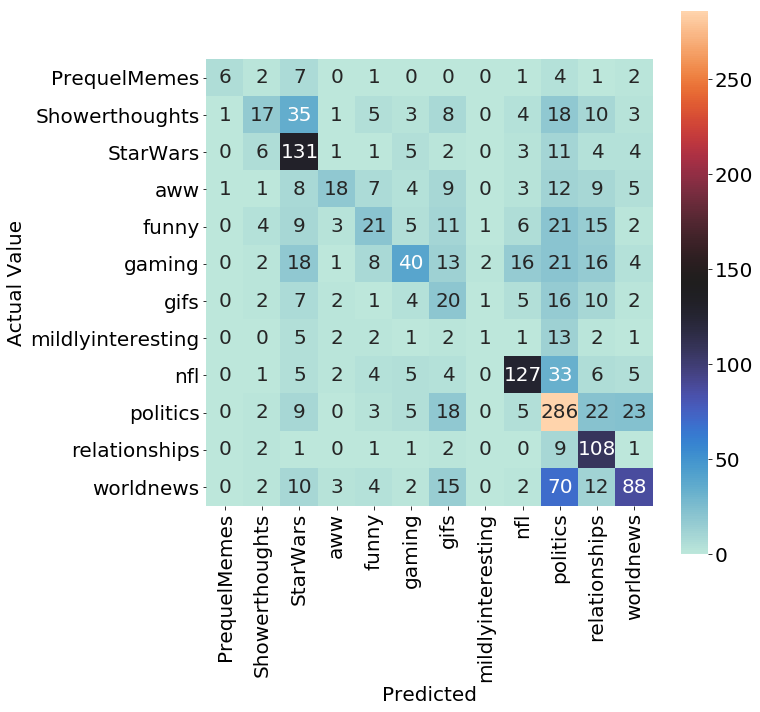

In [41]:
MNB = MultinomialNB(alpha=0.01)
MNB.fit(trcombostack, y_train)
y_pred = MNB.predict(tecombostack)
cm = pd.crosstab(y_test, y_pred)

print(sklearn.metrics.accuracy_score(y_test, y_pred))
plotConfusionMatrix(cm)

<p>Hmmm, a decrease in accuracy...score and gilded is not helping at all. We'll have to try something else. Flairs!</p>

In [42]:
vectorizer = TfidfVectorizer(min_df=1, max_features=15000)
vectorizer2 = TfidfVectorizer(min_df=1, max_features=15000)
vectorizer3 = TfidfVectorizer(min_df=1, max_features=15000)

In [43]:
trainingdata, testingdata, y_train, y_test = train_test_split(above50t[["body", "author_flair_css_class","author_flair_text"]], above50t["subreddit"], test_size = 1/5)

In [44]:
traintf1 = vectorizer.fit_transform(trainingdata["body"])
traintf2 = vectorizer2.fit_transform(trainingdata["author_flair_css_class"])
traintf3 = vectorizer3.fit_transform(trainingdata["author_flair_text"])
testtf1 = vectorizer.transform(testingdata["body"])
testtf2 = vectorizer2.transform(testingdata["author_flair_css_class"])
testtf3 = vectorizer3.transform(testingdata["author_flair_text"])

trcombostack = hstack([traintf1, traintf2, traintf3])
tecombostack = hstack([testtf1, testtf2, testtf3])

print(trcombostack.shape)
print(tecombostack.shape)

(6443, 15367)
(1611, 15367)


0.6672873991309746


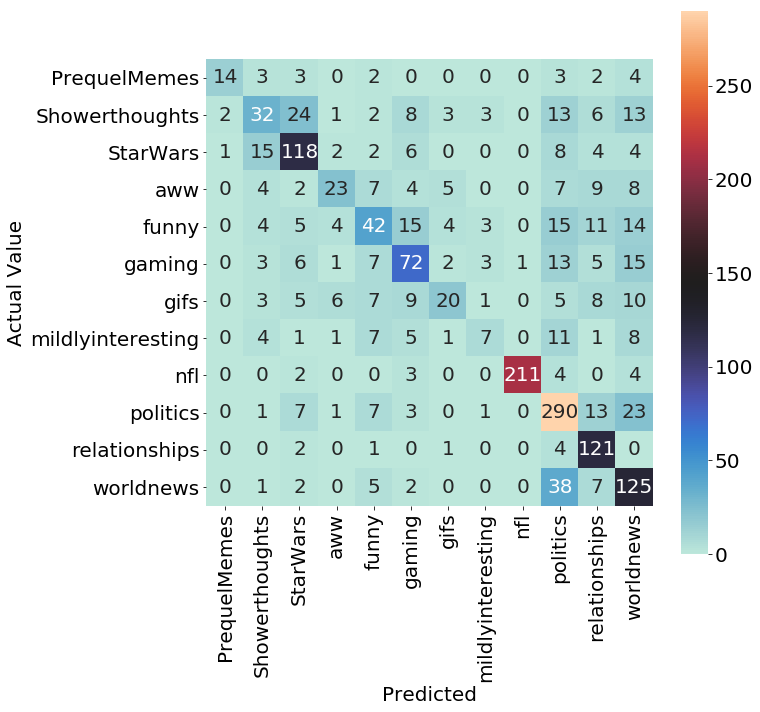

In [45]:
MNB = MultinomialNB(alpha=0.01)
MNB.fit(trcombostack, y_train)
y_pred = MNB.predict(tecombostack)
cm = pd.crosstab(y_test, y_pred)

print(sklearn.metrics.accuracy_score(y_test, y_pred))
plotConfusionMatrix(cm)

<p>Wow, 66%! Let's try this with SVC.</p>

0.6399751707014277


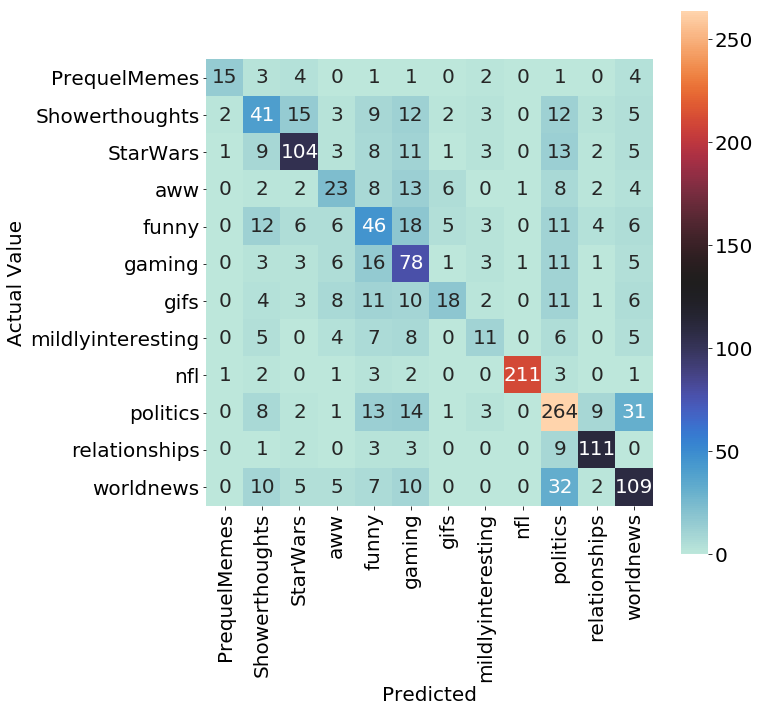

In [47]:
SVM = SVC(kernel='sigmoid', gamma="auto", C=1E5)
SVM.fit(trcombostack, y_train)
y_pred = SVM.predict(tecombostack)
cm = pd.crosstab(y_test, y_pred)

print(sklearn.metrics.accuracy_score(y_test, y_pred))
plotConfusionMatrix(cm)

<p>It seems that Naive Bayes is winning over Support Vectors on this front. Looking at the confusion matrices more closely, Support Vectors missclassifies things on politics (the largest data portion) less, but then missclassifies the other labels more often than Naive Bayes. Let's run a quick cross-validation section just to make sure these findings hold up.</p>

In [48]:
traintf1 = vectorizer.fit_transform(above50t["body"])
traintf2 = vectorizer2.fit_transform(above50t["author_flair_css_class"])
traintf3 = vectorizer3.fit_transform(above50t["author_flair_text"])

trcombostack = hstack([traintf1, traintf2, traintf3])

In [49]:
MNB = MultinomialNB(alpha=0.01)
scores = cross_validate(MNB, trcombostack, above50t["subreddit"], cv=5)
print(scores)
print("Test average :",scores["test_score"].mean())

{'fit_time': array([0.39195442, 0.22398686, 0.2159791 , 0.19198394, 0.16798568]), 'score_time': array([0.01600766, 0.01599503, 0.00798988, 0.01599884, 0.01602626]), 'test_score': array([0.60519802, 0.63935444, 0.61428571, 0.62670807, 0.5955196 ]), 'train_score': array([0.95417832, 0.95328263, 0.95391061, 0.95779019, 0.95656895])}
Test average : 0.6162131697202706


In [50]:
SVM = SVC(kernel='sigmoid', gamma="auto", C=1E5)
scores = cross_validate(SVM, trcombostack, above50t["subreddit"], cv=5)
print(scores)
print("Test average :",scores["test_score"].mean())

{'fit_time': array([66.64171743, 62.57784629, 65.54905653, 79.24459863, 69.12032628]), 'score_time': array([ 8.81600261,  9.1511426 , 12.45505905,  9.30179143,  8.78650594]), 'test_score': array([0.55940594, 0.5735568 , 0.55714286, 0.58881988, 0.55196017]), 'train_score': array([0.99394222, 0.99441254, 0.99472377, 0.99410304, 0.99612223])}
Test average : 0.5661771289543017


<p>In the end, Naive Bayes has come ahed of support vectors, which is surprising since most of the time it is the opposite. I suspect that not being able to optimize the SVC as well as Multinomial was is the main contributor. Otherwise, I have no idea what else could be causing this.</p>
<p>Moving on, the flairs for each subreddit seem to be helping the accuracy. Score and gilded seemed to cause the accuracy to decrease and thus not be as helpful.</p>
<p>I'm running out of time so I can't try out as much, but my next step if I had more time would be the following:</p>
<ul>
    <li>Taking more time to fine tune SVC, specially since there's more options to play around with</li>
    <li>Doing more feature combinations</li>
    <li>Running Gridsearch on the model parameters again after locating the most optimal features with the fine tuned models.</li>
</ul>

<a id="publishing"></a>
<h2>Publishing Data [<a href="#toc">TOC</a>]</h2>
<p>Since my dataframe is rather small, I can afford to publish it under data samples for those who would want to experiment with the exact same data.</p>

In [51]:
above50t.to_json("../data_samples/above50t.json")
above50t.to_csv("../data_samples/above50t.csv")